In [1]:
from torch import nn, optim
import torch
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.linear_layer = nn.Linear(input_size, output_size, dtype=torch.float64)

    def forward(self, x):
        # print(x)
        x = torch.pow(x, torch.arange(0, self.input_size, device=x.device))
        # print(x)
        x = self.linear_layer(x)
        return x

In [3]:
class Config:
    num_epochs = 10
    batch_size = 1024
    lr = 1e-1
    range = (-10, 10)
    fitting_order = 25 # 多项式拟合函数的次数
    noise_mean = 0 # 噪声正态分布均值
    noise_std = 0.1 # 噪声正态分布标准差
    train_dataset_sample_num = 1000000

In [4]:
target_func = lambda x: 2 * x * np.cos(2 * x) * (x * x + 7 * x + 1)

def generate_dataset(num_samples: int, is_train: bool):
    X = np.random.uniform(Config.range[0], Config.range[1], (num_samples, 1))
    noise = None
    if is_train:
        noise = np.random.normal(Config.noise_mean, Config.noise_std, (num_samples, 1))
    else:
        noise = 0
    Y = target_func(X) + noise
    X = X / Config.range[1]
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y)
    return (X, Y)

train_X, train_Y = generate_dataset(Config.train_dataset_sample_num, True)

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [5]:
def loss(y_hat, y_truth):
    return nn.MSELoss()(y_hat, y_truth)

Epoch [1/10], Step [100], Loss: 510697.96572547685
Epoch [1/10], Step [200], Loss: 437479.35400357464
Epoch [1/10], Step [300], Loss: 447341.6653324332
Epoch [1/10], Step [400], Loss: 429763.8149692626
Epoch [1/10], Step [500], Loss: 430079.78345566685
Epoch [1/10], Step [600], Loss: 447061.2162267169
Epoch [1/10], Step [700], Loss: 387481.3162581658
Epoch [1/10], Step [800], Loss: 407952.8089219594
Epoch [1/10], Step [900], Loss: 387197.9561890395
Epoch [2/10], Step [100], Loss: 358378.0993375188
Epoch [2/10], Step [200], Loss: 348146.8032689721
Epoch [2/10], Step [300], Loss: 349045.76177171967
Epoch [2/10], Step [400], Loss: 360223.81093384704
Epoch [2/10], Step [500], Loss: 336478.81158022786
Epoch [2/10], Step [600], Loss: 359422.6994336265
Epoch [2/10], Step [700], Loss: 351991.4035419912
Epoch [2/10], Step [800], Loss: 328176.1189533445
Epoch [2/10], Step [900], Loss: 360076.95365637157
Epoch [3/10], Step [100], Loss: 361359.33431720897
Epoch [3/10], Step [200], Loss: 305003.414

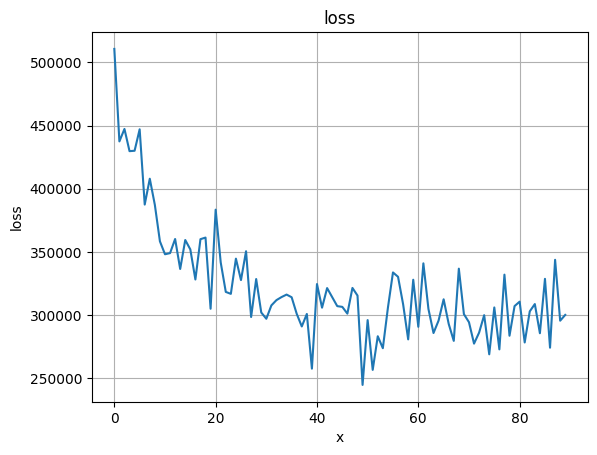

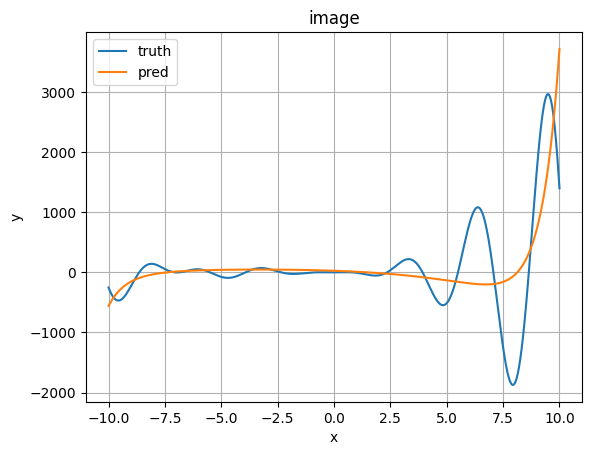

In [6]:
def train():
    net = Linear(Config.fitting_order+1, 1).to("cuda:0")
    optimizer = optim.Adam(net.parameters(), lr=Config.lr)
    data_iter = load_array((train_X, train_Y), batch_size=Config.batch_size)
    loss_list = []
    net.train()
    for epoch in range(Config.num_epochs):
        for i, (X, Y) in enumerate(data_iter):
            X = X.to("cuda:0")
            Y = Y.to("cuda:0")
            optimizer.zero_grad()
            l = loss(net(X), Y)
            l = l.mean()
            l.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{Config.num_epochs}], Step [{i+1}], Loss: {l}')
                loss_list.append(l.cpu())
    


    net.eval()
    # print(net.parameters)
    net.to("cpu")
    with torch.no_grad():
        # loss_list = loss_list
        plt.plot(np.arange(len(loss_list)), loss_list)
        plt.xlabel('x')
        plt.ylabel('loss')
        plt.title('loss')
        plt.grid(True)
        plt.show()
        
        X = torch.linspace(Config.range[0], Config.range[1], 20000, dtype=torch.float64)
        Y = target_func(X)
        Y_hat = net((X / Config.range[1]).reshape(-1, 1)).reshape(-1)
        plt.plot(X, Y, label="truth")
        plt.plot(X, Y_hat, label="pred")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('image')
        plt.legend()
        plt.grid(True)
        plt.show()

train()